# Attraction Basin Analysis

이 노트북은 **Unconditional Trajectory**를 기준으로 **Attraction Basin**을 탐지하는 로직을 분석하고 시각화합니다.

## Theory
Attraction Basin은 Conditional Noise와 Unconditional Noise 간의 거리(Norm Difference)가 급격하게 감소하는 구간으로 정의됩니다.

$$ \Delta_t = \| \epsilon_\theta(z_t, c) - \epsilon_\theta(z_t, \emptyset) \|_2 $$

Basin 진입 시점(Attraction Point)은 $\Delta_t$의 감소율이 최대(Gradient가 최소)인 지점으로 결정합니다:

$$ t^* = \operatorname*{argmin}_{t > t_{\text{warmup}}} (\Delta_{t+1} - \Delta_t) $$


In [2]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from diffusers import DDIMScheduler
from local_sd_pipeline import LocalStableDiffusionPipeline
import random

# Configuration
MODEL_ID = "CompVis/stable-diffusion-v1-4"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
NUM_STEPS = 50

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(SEED)

In [3]:
def load_prompts():
    # Memorized
    try:
        df_mem = pd.read_csv('prompts/memorized_laion_prompts.csv', sep=';')
        memorized = df_mem['Caption'].tolist()[:100]
    except Exception as e:
        print(f"Error loading memorized prompts: {e}")
        memorized = []

    # Unmemorized
    try:
        df_unmem = pd.read_csv('prompts/unmemorized_prompts.csv', sep=';')
        unmemorized = df_unmem['Caption'].tolist()[:100]
    except Exception as e:
        print(f"Error loading unmemorized prompts: {e}")
        unmemorized = []
            
    return memorized, unmemorized

memorized_prompts, unmemorized_prompts = load_prompts()
print(f"Memorized: {len(memorized_prompts)}, Unmemorized: {len(unmemorized_prompts)}")

Memorized: 100, Unmemorized: 100


In [4]:
# Load Model
print("Loading pipeline...")
pipeline = LocalStableDiffusionPipeline.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float32, 
    requires_safety_checker=False
).to(DEVICE)
pipeline.set_progress_bar_config(disable=True)

# Set Scheduler
pipeline.scheduler.set_timesteps(NUM_STEPS, device=DEVICE)
timesteps = pipeline.scheduler.timesteps

Loading pipeline...


/home/gpuadmin/cssin/init_noise_diffusion_memorization/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### 1. Unconditional Trajectory Generation
먼저, 아무런 조건이 없는 상태(Unconditional, $\emptyset$)에서의 Diffusion 경로를 생성합니다.
이 경로는 이후 모든 Prompt들의 Attraction Basin을 판단하는 기준점(Reference)이 됩니다.

In [5]:
print("Generating Unconditional Trajectory...")

# Null Prompt Embedding
unc_prompt_embeds = pipeline._encode_prompt("", DEVICE, 1, False, None)

# Calculate dimensions
height = pipeline.unet.config.sample_size * pipeline.vae_scale_factor
width = pipeline.unet.config.sample_size * pipeline.vae_scale_factor

# Prepare Initial Latents (Fixed Seed)
# latents: [1, 4, 64, 64] -> [B, C, H, W]
latents = pipeline.prepare_latents(
    1, pipeline.unet.config.in_channels, height, width,
    torch.float32, torch.device(DEVICE), torch.Generator(device=DEVICE).manual_seed(SEED), None
)

trajectory_latents = [] 
trajectory_uncond_noise = []

curr_latents = latents
with torch.no_grad():
    for i, t in enumerate(tqdm(timesteps, desc="Uncond Trajectory")):
        trajectory_latents.append(curr_latents.clone())
        
        # Predict noise
        latent_model_input = pipeline.scheduler.scale_model_input(curr_latents, t)
        noise_pred = pipeline.unet(latent_model_input, t, encoder_hidden_states=unc_prompt_embeds).sample
        
        trajectory_uncond_noise.append(noise_pred.clone())
        
        # Step (Unconditional)
        curr_latents = pipeline.scheduler.step(noise_pred, t, curr_latents, return_dict=False)[0]

print("Unconditional Trajectory Generated.")



Generating Unconditional Trajectory...


Uncond Trajectory: 100%|██████████| 51/51 [00:03<00:00, 13.94it/s]

Unconditional Trajectory Generated.


In [19]:
print(len(trajectory_latents))
print(len(trajectory_uncond_noise))
print(trajectory_latents[0].shape)
print(trajectory_uncond_noise[0].shape)

51
51
torch.Size([1, 4, 64, 64])
torch.Size([1, 4, 64, 64])


### 2. Attraction Basin Detection
각 Prompt에 대해 Conditional Noise를 계산하고, Unconditional Noise와의 차이를 측정하여 Attraction Basin을 탐지합니다.

In [16]:
def analyze_attraction_basin(prompts, group_name):
    results = []
    curves = []
    
    for prompt in tqdm(prompts, desc=f"{group_name}"):
        # Encode prompt
        cond_embeds = pipeline._encode_prompt(prompt, DEVICE, 1, False, None)
        
        diff_norms = []
        cos_sims = []
        
        with torch.no_grad():
            for i, t in enumerate(timesteps):
                # Reuse state from unconditional trajectory
                lat = trajectory_latents[i]
                latent_input = pipeline.scheduler.scale_model_input(lat, t)
                
                # Cond Noise Calculation
                cond_noise = pipeline.unet(latent_input, t, encoder_hidden_states=cond_embeds).sample
                uncond_noise = trajectory_uncond_noise[i]
                
                # Calculate L2 Norm of Difference
                diff = torch.norm(cond_noise - uncond_noise).item()
                diff_norms.append(diff)
                
                # Calculate Cosine Similarity
                # Flatten [1, 4, 64, 64] -> [16384]
                c_flat = cond_noise.view(-1)
                u_flat = uncond_noise.view(-1)
                
                dot_prod = torch.dot(c_flat, u_flat)
                norm_c = torch.norm(c_flat)
                norm_u = torch.norm(u_flat)
                cos_sim = (dot_prod / (norm_c * norm_u + 1e-8)).item()
                cos_sims.append(cos_sim)
        
        curves.append(diff_norms)
        
        # Detect Basin Drop
        curve_arr = np.array(diff_norms)
        deriv = np.diff(curve_arr)
        
        # Find steepest drop after warmup
        # offset 5 steps to avoid initial instability
        t_drop_idx = np.argmin(deriv[5:]) + 5
        
        results.append({
            "Prompt": prompt,
            "Group": group_name,
            "Curve": curve_arr,
            "Cos_Curve": np.array(cos_sims),
            "Drop_Index": t_drop_idx
        })
        
    return results

# Run Analysis
mem_results = analyze_attraction_basin(memorized_prompts, "Memorized")
unmem_results = analyze_attraction_basin(unmemorized_prompts, "Unmemorized")

Memorized:   6%|▌         | 6/100 [00:23<06:11,  3.95s/it]


KeyboardInterrupt: 

### 3. Visualization: Norm Difference Basin Dynamics
Memorized Prompt와 Unmemorized Prompt의 Conditional - Unconditional Noise Difference Norm을 시각화합니다.

In [ ]:
import math
from matplotlib.lines import Line2D

# Calculate Global Y-Limits for Unified Scale
all_curves = [res['Curve'] for res in mem_results] + [res['Curve'] for res in unmem_results]
if all_curves:
    global_max = max([np.max(c) for c in all_curves])
    global_min = min([np.min(c) for c in all_curves])
else:
    global_max = 1.0
    global_min = 0.0

# Setup Subplots (5x4 grid = 20 plots)
n_subplots = 20
cols = 4
rows = math.ceil(n_subplots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows), constrained_layout=True)
axes = axes.flatten()

samples_per_plot = 5

for i in range(n_subplots):
    if i >= len(axes): break
    ax = axes[i]
    start_idx = i * samples_per_plot
    end_idx = (i + 1) * samples_per_plot
    
    # Memorized Subset
    subset_mem = mem_results[start_idx:end_idx] if start_idx < len(mem_results) else []
    for res in subset_mem:
        ax.plot(res['Curve'], color='red', alpha=0.3)
        ax.axvline(res['Drop_Index'], color='red', linestyle=':', alpha=0.2)
        
    # Unmemorized Subset
    subset_unmem = unmem_results[start_idx:end_idx] if start_idx < len(unmem_results) else []
    for res in subset_unmem:
        ax.plot(res['Curve'], color='blue', alpha=0.3)
        
    # Set Unified Y-Limit
    ax.set_ylim(global_min, global_max)
    ax.set_title(f"Batch {i+1}")
    ax.grid(True, alpha=0.3)
    if i >= (rows-1)*cols: # Last row
        ax.set_xlabel("Diffusion Step")
    if i % cols == 0: # First col
        ax.set_ylabel("Norm Diff")
    
# Legend
custom_lines = [Line2D([0], [0], color='red', lw=2), 
                Line2D([0], [0], color='blue', lw=2)]
fig.legend(custom_lines, ['Memorized', 'Unmemorized'], loc='upper center', ncol=2, fontsize=14, bbox_to_anchor=(0.5, 1.03))

plt.suptitle(f"Attraction Basin Dynamics (5 Mem vs 5 Unmem per plot)", fontsize=16, y=1.05)
plt.show()

### 4. Visualization: Cosine Similarity
Conditional Noise와 Unconditional Noise 간의 Cosine Similarity를 시각화합니다.
변수 `X_LIM`을 조절하여 X축(Timestep)의 범위를 변경할 수 있습니다.

In [ ]:
# Configurable X-Axis Limit
X_LIM = (0, 50)  # (Start, End)

# Setup Subplots (5x4 grid = 20 plots)
n_subplots = 20
cols = 4
rows = math.ceil(n_subplots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows), constrained_layout=True)
axes = axes.flatten()

samples_per_plot = 5

# Calculate Global Y-Limits for Cosine Sim
all_cos_curves = [res['Cos_Curve'] for res in mem_results] + [res['Cos_Curve'] for res in unmem_results]
if all_cos_curves:
    cos_global_max = max([np.max(c) for c in all_cos_curves])
    cos_global_min = min([np.min(c) for c in all_cos_curves])
else:
    cos_global_max = 1.0
    cos_global_min = -1.0

for i in range(n_subplots):
    if i >= len(axes): break
    ax = axes[i]
    start_idx = i * samples_per_plot
    end_idx = (i + 1) * samples_per_plot
    
    # Memorized Subset
    subset_mem = mem_results[start_idx:end_idx] if start_idx < len(mem_results) else []
    for res in subset_mem:
        ax.plot(res['Cos_Curve'], color='red', alpha=0.3)
        ax.axvline(res['Drop_Index'], color='red', linestyle=':', alpha=0.2)
        
    # Unmemorized Subset
    subset_unmem = unmem_results[start_idx:end_idx] if start_idx < len(unmem_results) else []
    for res in subset_unmem:
        ax.plot(res['Cos_Curve'], color='blue', alpha=0.3)
        
    # Set Unified Y-Limit & Configurable X-Limit
    ax.set_ylim(cos_global_min, cos_global_max)
    ax.set_xlim(X_LIM)
    ax.set_title(f"Batch {i+1}")
    ax.grid(True, alpha=0.3)
    if i >= (rows-1)*cols: # Last row
        ax.set_xlabel("Diffusion Step")
    if i % cols == 0: # First col
        ax.set_ylabel("Cosine Similarity")
    
# Legend
custom_lines = [Line2D([0], [0], color='red', lw=2), 
                Line2D([0], [0], color='blue', lw=2)]
fig.legend(custom_lines, ['Memorized', 'Unmemorized'], loc='upper center', ncol=2, fontsize=14, bbox_to_anchor=(0.5, 1.03))

plt.suptitle(f"Cosine Similarity Dynamics (X-Axis: {X_LIM})", fontsize=16, y=1.05)
plt.show()

### 5. Outlier Detection
특정 Time Step 이후에도 Norm Difference가 높은(Basin을 빠져나오지 못한) Prompt를 필터링합니다.
Default: `threshold_step=40`, `threshold_value=10.0`

In [ ]:
def filter_outliers(results, threshold_step=40, threshold_value=10.0):
    outliers = []
    for res in results:
        curve = res['Curve']
        # Check if max value after threshold_step exceeds threshold_value
        # Safety check for length
        if len(curve) > threshold_step:
            # We look at the value AT the step or max AFTER the step?
            # User said "After 40 step, Norm diff >= 10"
            # Let's check if ANY point >= 10 exists after step 40
            late_curve = curve[threshold_step:]
            if np.max(late_curve) >= threshold_value:
                outliers.append(res)
    return outliers

# Filter Memorized Outliers
outlier_mem = filter_outliers(mem_results, threshold_step=40, threshold_value=10.0)
print(f"Found {len(outlier_mem)} outliers out of {len(mem_results)} memorized prompts.")

# Display Outliers
if outlier_mem:
    plt.figure(figsize=(10, 6))
    for res in outlier_mem:
        plt.plot(res['Curve'], label=f"Index: {prompts.index(res['Prompt']) if 'prompts' in locals() else 'N/A'}", alpha=0.7)
    
    plt.axvline(40, color='k', linestyle='--', label='Threshold Step (40)')
    plt.axhline(10, color='k', linestyle=':', label='Threshold Value (10.0)')
    plt.title("Outlier Memorized Prompts (High Norm Diff at Late Steps)")
    plt.xlabel("Diffusion Step")
    plt.ylabel("Norm Diff")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Print Prompts
    print("\n--- Outlier Prompts ---")
    for i, res in enumerate(outlier_mem):
        print(f"{i+1}. {res['Prompt']}")
else:
    print("No outliers found matching the criteria.")

### 7. Outlier Switching Analysis
Outlier로 감지된 Prompt들에 대해, **Unconditional -> Conditional** 전환 시점을 0부터 50까지 5단위로 조절하며 이미지를 생성합니다.

1. **Switching Generation**: 0, 5, ..., 50 Step에서 Unconditional에서 Conditional로 전환.
2. **L2 Distance Plot**: Fully Conditional (Step 0) 결과와의 L2 Distance 비교.
3. **Visual Comparison**: 생성된 이미지 그리드 시각화.

In [ ]:
switch_steps = list(range(0, 51, 5)) # 0, 5, ..., 50
outlier_prompts_list = [res['Prompt'] for res in outlier_mem]

if not outlier_prompts_list:
    print("No outliers to analyze.")
else:
    print(f"Analyzing {len(outlier_prompts_list)} outliers across {len(switch_steps)} switch steps...")
    
    # 1. Prepare Batch Embeddings
    cond_embeds_list = []
    for p in outlier_prompts_list:
        cond_embeds_list.append(pipeline._encode_prompt(p, DEVICE, 1, False, None))
    batch_cond = torch.cat(cond_embeds_list) # [N, 77, 768]
    
    # Repeat Uncond Embeds
    uc = pipeline._encode_prompt("", DEVICE, 1, False, None)
    batch_uc = uc.repeat(len(outlier_prompts_list), 1, 1)
    
    # 2. Prepare Fixed Initial Latents
    # Use a consistent seed for the batch to ensure comparison validity
    gen = torch.Generator(device=DEVICE).manual_seed(SEED)
    init_latents = pipeline.prepare_latents(
        len(outlier_prompts_list), pipeline.unet.config.in_channels, height, width,
        torch.float32, torch.device(DEVICE), gen, None
    )
    
    results_switching = {} # switch_step -> Images (numpy [N, H, W, 3])
    
    # 3. Optimized Simulation Loop
    # First, generate FULL Unconditional Trajectory for the batch to cache states
    print("Generating base Unconditional Trajectory via batch...")
    curr_latents = init_latents.clone()
    pipeline.scheduler.set_timesteps(NUM_STEPS, device=DEVICE)
    
    # Cache latents at each step: index -> latents tensor
    uncond_latents_cache = {}
    
    with torch.no_grad():
        for i, t in enumerate(pipeline.scheduler.timesteps):
            # Save current state before stepping
            uncond_latents_cache[i] = curr_latents.clone()
            
            # Predict Noise (Uncond)
            latent_input = pipeline.scheduler.scale_model_input(curr_latents, t)
            noise_pred = pipeline.unet(latent_input, t, encoder_hidden_states=batch_uc).sample
            
            # Step
            curr_latents = pipeline.scheduler.step(noise_pred, t, curr_latents, return_dict=False)[0]
            
    # Last state (fully uncond image latents)
    uncond_latents_cache[len(pipeline.scheduler.timesteps)] = curr_latents.clone()

    # Now run branching generation
    for s_step in tqdm(switch_steps, desc="Switch Simulation"):
        # Resume from cached unconditional state at s_step
        # If s_step == 50, strictly it is fully uncond, so we can just use cache[50]
        # The cache[i] is the input to step i. 
        # So if we switch AT step i (meaning step i is conditional), we start with cache[i].
        
        if s_step >= len(pipeline.scheduler.timesteps):
             # Fully Unconditional
             curr_latents = uncond_latents_cache[len(pipeline.scheduler.timesteps)]
        else:
             curr_latents = uncond_latents_cache[s_step].clone()
             
             # Run remaining steps conditionally
             with torch.no_grad():
                 for i in range(s_step, len(pipeline.scheduler.timesteps)):
                     t = pipeline.scheduler.timesteps[i]
                     latent_input = pipeline.scheduler.scale_model_input(curr_latents, t)
                     noise_pred = pipeline.unet(latent_input, t, encoder_hidden_states=batch_cond).sample
                     curr_latents = pipeline.scheduler.step(noise_pred, t, curr_latents, return_dict=False)[0]
        
        # Decode Images in Batches to avoid OOM
        latents_scaled = curr_latents / pipeline.vae.config.scaling_factor
        decoded_images = []
        batch_size_vae = 1 # conservative batch size for VAE
        
        for i in range(0, len(latents_scaled), batch_size_vae):
            batch_latents = latents_scaled[i:i+batch_size_vae]
            with torch.no_grad():
                batch_imgs = pipeline.vae.decode(batch_latents, return_dict=False)[0]
            decoded_images.append(batch_imgs)
        
        images = torch.cat(decoded_images, dim=0)
        
        # Post-process
        images = (images / 2 + 0.5).clamp(0, 1)
        images = images.cpu().permute(0, 2, 3, 1).numpy()
        results_switching[s_step] = images
        
    # 4. Analysis: L2 Distance from Fully Conditional (Step 0)
    baseline_imgs = results_switching[0]
    distances_per_prompt = {i: [] for i in range(len(outlier_prompts_list))}
    
    for s_step in switch_steps:
        current_imgs = results_switching[s_step]
        for i in range(len(outlier_prompts_list)):
            # Flatten and calc Euclidean Distance
            diff = current_imgs[i].flatten() - baseline_imgs[i].flatten()
            dist = np.linalg.norm(diff)
            distances_per_prompt[i].append(dist)
            
    # Plot Distances (Aggregate)
    plt.figure(figsize=(12, 6))
    for i, dists in distances_per_prompt.items():
        plt.plot(switch_steps, dists, marker='o', label=f"Prompt {i}")
    plt.title("Impact of Unconditional Duration on Final Image Norm Diff")
    plt.xlabel("Switch Step (Uncond -> Cond)")
    plt.ylabel("L2 Distance from Fully Conditional (Step 0)")
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # 6. Combined Analysis Plot per Prompt
    print("\n--- Individual Prompt Analysis: Norm Diff Curve vs Switch Impact ---")
    for i, res in enumerate(outlier_mem):
        fig, ax1 = plt.subplots(figsize=(14, 5))
        
        # Left: Attraction Basin Curve (Norm Diff) - from Section 2
        color = 'tab:red'
        ax1.set_xlabel('Diffusion Step')
        ax1.set_ylabel('Attraction Basin Norm Diff (Cond-Uncond)', color=color)
        ax1.plot(res['Curve'], color=color, linewidth=2, label='Attraction Basin Curve')
        ax1.axvline(res['Drop_Index'], color=color, linestyle='--', label=f'Basin Exit: {res["Drop_Index"]}')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.grid(True, alpha=0.3)
        
        # Right Axis: Switch Impact (L2 Dist from Fully Cond)
        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('Visual Difference (L2 Dist from Fully Cond)', color=color)
        
        # Switch steps are specific integers (0, 5, 10...), plot them against the SAME x-axis (Diffusion Step)
        # The switch step IS the diffusion step where we switch.
        ax2.plot(switch_steps, distances_per_prompt[i], color=color, marker='o', linestyle='-', linewidth=2, label='Switch Impact')
        ax2.tick_params(axis='y', labelcolor=color)
        
        plt.title(f"Prompt {i}: {res['Prompt'][:60]}...")
        
        # Combine legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center')
        
        plt.tight_layout()
        plt.show()
    
    plt.show()

    # 7. Visual Comparison Grid
    n_prompts = len(outlier_prompts_list)
    n_cols = len(switch_steps)
    
    # Limit visualization if too many outliers? Let's show all for now since they are 'outliers' (few)
    fig, axes = plt.subplots(n_prompts, n_cols, figsize=(2.5 * n_cols, 2.5 * n_prompts))
    
    # Ensure axes is 2D array
    if n_prompts == 1:
        axes = np.array([axes])
    if n_cols == 1:
        axes = np.array([[ax] for ax in axes])
        
    for i in range(n_prompts):
        for j, s_step in enumerate(switch_steps):
            ax = axes[i][j]
            img = results_switching[s_step][i]
            ax.imshow(img)
            ax.axis('off')
            if i == 0:
                ax.set_title(f"Switch @ {s_step}", fontsize=10)
            if j == 0:
                ax.text(-0.3, 0.5, f"Prompt {i}", transform=ax.transAxes, va='center', rotation=90, fontsize=10)
                
    plt.tight_layout()
    plt.show()

### 8. Pure Noise Input Analysis (Hypothesis Testing)
**가설**: Attraction Basin 안에서의 동작은 Trajectory History보다는, 해당 Time Step에서의 Noise Distribution과 관련이 있을 것이다.
이를 검증하기 위해, Trajectory를 따라가는 대신 매 Time Step마다 새로운 **Random Gaussian Noise ($z \sim \mathcal{N}(0, I)$)**를 입력으로 넣어 Norm Difference를 측정합니다.

In [ ]:
print("Generating Unconditional Trajectory...")

# Null Prompt Embedding
unc_prompt_embeds = pipeline._encode_prompt("", DEVICE, 1, False, None)

# Calculate dimensions
height = pipeline.unet.config.sample_size * pipeline.vae_scale_factor
width = pipeline.unet.config.sample_size * pipeline.vae_scale_factor

# Prepare Initial Latents (Fixed Seed)
# latents: [1, 4, 64, 64] -> [B, C, H, W]

trajectory_latents = [] 
trajectory_uncond_noise = []

curr_latents = latents
with torch.no_grad():
    for i, t in enumerate(tqdm(timesteps, desc="Uncond Trajectory")):
        curr_latents = pipeline.prepare_latents(
            1, pipeline.unet.config.in_channels, height, width,
            torch.float32, torch.device(DEVICE), torch.Generator(device=DEVICE), None
        )
        # Store Latents
        trajectory_latents.append(curr_latents.clone())
        
        # Predict noise
        latent_model_input = pipeline.scheduler.scale_model_input(curr_latents, t)
        noise_pred = pipeline.unet(latent_model_input, t, encoder_hidden_states=unc_prompt_embeds).sample
        
        trajectory_uncond_noise.append(noise_pred.clone())

print("Unconditional Trajectory Generated.")



Generating Unconditional Trajectory...


Uncond Trajectory: 100%|██████████| 51/51 [00:03<00:00, 15.15it/s]

Unconditional Trajectory Generated.


Generating Unconditional Trajectory (Pure Noise Input)...


Uncond Trajectory:   0%|          | 0/51 [00:00<?, ?it/s]

Uncond Trajectory:   2%|▏         | 1/51 [00:00<00:06,  7.57it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


Uncond Trajectory:   6%|▌         | 3/51 [00:00<00:04, 11.72it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


Uncond Trajectory:  10%|▉         | 5/51 [00:00<00:03, 13.04it/s]

tensor(0., device='cuda:0')


Uncond Trajectory:  14%|█▎        | 7/51 [00:00<00:03, 13.66it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


Uncond Trajectory:  18%|█▊        | 9/51 [00:00<00:03, 13.94it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


Uncond Trajectory:  22%|██▏       | 11/51 [00:00<00:02, 14.12it/s]

tensor(0., device='cuda:0')


Uncond Trajectory:  25%|██▌       | 13/51 [00:00<00:02, 14.28it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


Uncond Trajectory:  29%|██▉       | 15/51 [00:01<00:02, 14.38it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


Uncond Trajectory:  33%|███▎      | 17/51 [00:01<00:02, 14.49it/s]

tensor(0., device='cuda:0')


Uncond Trajectory:  37%|███▋      | 19/51 [00:01<00:02, 14.57it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


Uncond Trajectory:  41%|████      | 21/51 [00:01<00:02, 14.57it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


Uncond Trajectory:  45%|████▌     | 23/51 [00:01<00:01, 14.62it/s]

tensor(0., device='cuda:0')


Uncond Trajectory:  49%|████▉     | 25/51 [00:01<00:01, 14.68it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


Uncond Trajectory:  53%|█████▎    | 27/51 [00:01<00:01, 14.66it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


Uncond Trajectory:  57%|█████▋    | 29/51 [00:02<00:01, 14.68it/s]

tensor(0., device='cuda:0')


Uncond Trajectory:  61%|██████    | 31/51 [00:02<00:01, 14.68it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


Uncond Trajectory:  65%|██████▍   | 33/51 [00:02<00:01, 14.64it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


Uncond Trajectory:  69%|██████▊   | 35/51 [00:02<00:01, 14.66it/s]

tensor(0., device='cuda:0')


Uncond Trajectory:  73%|███████▎  | 37/51 [00:02<00:00, 14.64it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


Uncond Trajectory:  76%|███████▋  | 39/51 [00:02<00:00, 14.59it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


Uncond Trajectory:  80%|████████  | 41/51 [00:02<00:00, 14.61it/s]

tensor(0., device='cuda:0')


Uncond Trajectory:  84%|████████▍ | 43/51 [00:03<00:00, 14.61it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


Uncond Trajectory:  88%|████████▊ | 45/51 [00:03<00:00, 14.59it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


Uncond Trajectory:  92%|█████████▏| 47/51 [00:03<00:00, 14.62it/s]

tensor(0., device='cuda:0')


Uncond Trajectory:  96%|█████████▌| 49/51 [00:03<00:00, 14.64it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


Uncond Trajectory: 100%|██████████| 51/51 [00:03<00:00, 14.35it/s]


Unconditional Trajectory Generated.


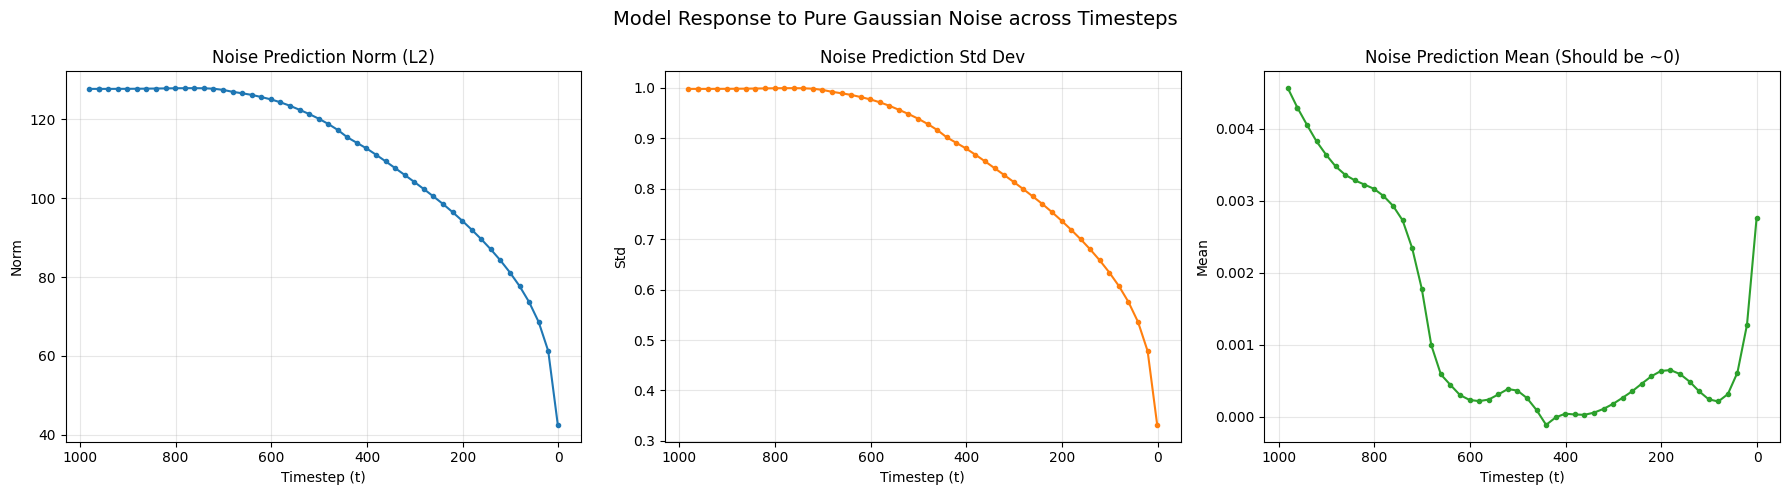

Decoding x0 predictions for visualization...


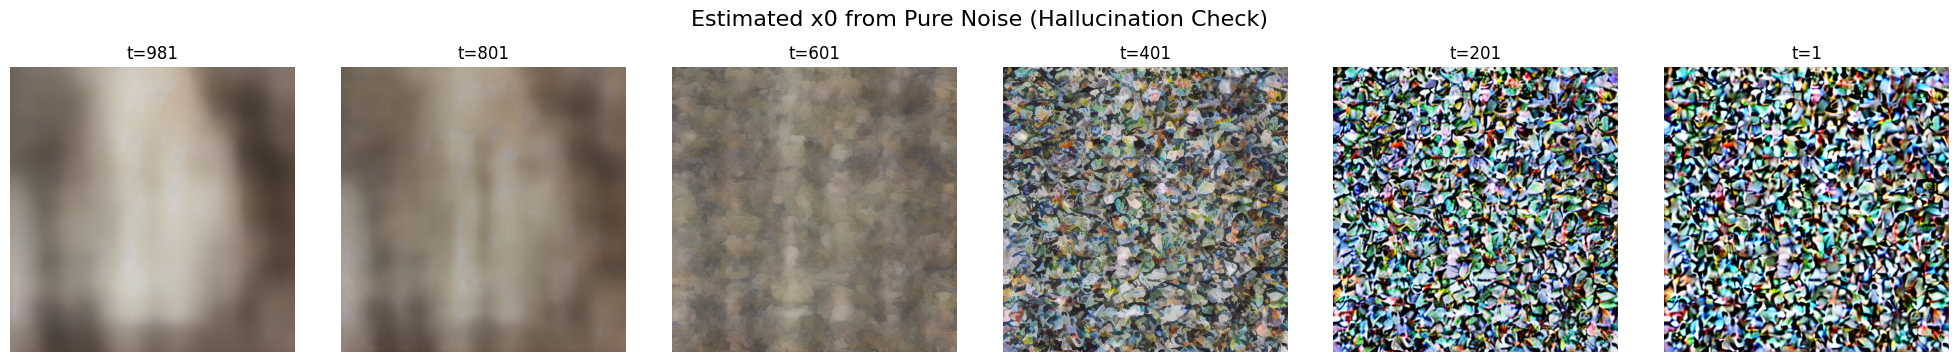

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
print("Generating Unconditional Trajectory (Pure Noise Input)...")
# 1. Setup & Generation Loop
# Null Prompt Embedding
unc_prompt_embeds = pipeline._encode_prompt("", DEVICE, 1, False, None)
# Calculate dimensions
height = pipeline.unet.config.sample_size * pipeline.vae_scale_factor
width = pipeline.unet.config.sample_size * pipeline.vae_scale_factor
trajectory_latents = [] 
trajectory_uncond_noise = []
trajectory_x0_preds = [] # To store x0 predictions for visualization
# Loop over timesteps
with torch.no_grad():
    tmp = pipeline.prepare_latents(
            1, pipeline.unet.config.in_channels, height, width,
            torch.float32, torch.device(DEVICE), torch.Generator(device=DEVICE), None
        )
    for i, t in enumerate(tqdm(timesteps, desc="Uncond Trajectory")):
        # Generate NEW Random Noise at each step (Hypothesis Testing)
        # latents: [1, 4, 64, 64]
        curr_latents = pipeline.prepare_latents(
            1, pipeline.unet.config.in_channels, height, width,
            torch.float32, torch.device(DEVICE), torch.Generator(device=DEVICE), None
        )
        
        print(torch.norm(curr_latents-tmp))
        tmp = curr_latents
        
        # Store Latents
        trajectory_latents.append(curr_latents.clone())
        
        # Predict noise
        # Note: Do not scale input for pure noise test usually, but pipeline requires scaling
        latent_model_input = pipeline.scheduler.scale_model_input(curr_latents, t)
        noise_pred = pipeline.unet(latent_model_input, t, encoder_hidden_states=unc_prompt_embeds).sample
        
        trajectory_uncond_noise.append(noise_pred.clone())
        
        # (Optional) Calculate x0 prediction to see what model 'sees'
        # x0 = (xt - sqrt(1-alpha_bar)*eps) / sqrt(alpha_bar)
        alpha_prod_t = pipeline.scheduler.alphas_cumprod[t]
        beta_prod_t = 1 - alpha_prod_t
        pred_original_sample = (curr_latents - beta_prod_t ** (0.5) * noise_pred) / alpha_prod_t ** (0.5)
        
        # Save x0 pred only for specific steps to save memory (e.g., every 10 steps)
        if i % 10 == 0:
            trajectory_x0_preds.append((t.item(), pred_original_sample.clone()))
print("Unconditional Trajectory Generated.")
# 2. Visualization
# Data Preparation
steps = [t.item() for t in timesteps] # x-axis
norms = [torch.norm(n).item() for n in trajectory_uncond_noise]
stds = [torch.std(n).item() for n in trajectory_uncond_noise]
means = [torch.mean(n).item() for n in trajectory_uncond_noise]
# Plot Statistics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# Plot 1: L2 Norm
axes[0].plot(steps, norms, color='tab:blue', marker='o', markersize=3)
axes[0].set_title("Noise Prediction Norm (L2)")
axes[0].set_xlabel("Timestep (t)")
axes[0].set_ylabel("Norm")
axes[0].invert_xaxis() # 1000 -> 0
axes[0].grid(True, alpha=0.3)
# Plot 2: Std Dev
axes[1].plot(steps, stds, color='tab:orange', marker='o', markersize=3)
axes[1].set_title("Noise Prediction Std Dev")
axes[1].set_xlabel("Timestep (t)")
axes[1].set_ylabel("Std")
axes[1].invert_xaxis()
axes[1].grid(True, alpha=0.3)
# Plot 3: Mean
axes[2].plot(steps, means, color='tab:green', marker='o', markersize=3)
axes[2].set_title("Noise Prediction Mean (Should be ~0)")
axes[2].set_xlabel("Timestep (t)")
axes[2].set_ylabel("Mean")
axes[2].invert_xaxis()
axes[2].grid(True, alpha=0.3)
plt.suptitle("Model Response to Pure Gaussian Noise across Timesteps", fontsize=14)
plt.tight_layout()
plt.show()
# 3. Visualize Hallucinations (x0 Predictions)
# Decode selected x0 predictions to see what the model hallucinates from pure noise
print("Decoding x0 predictions for visualization...")
n_vis = len(trajectory_x0_preds)
cols = 6
rows = (n_vis + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 3.5 * rows))
axes = axes.flatten()
for i, (t_val, lat) in enumerate(trajectory_x0_preds):
    with torch.no_grad():
        # VAE Decode
        lat_scaled = lat / pipeline.vae.config.scaling_factor
        image = pipeline.vae.decode(lat_scaled, return_dict=False)[0]
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
        
    axes[i].imshow(image)
    axes[i].set_title(f"t={t_val}")
    axes[i].axis('off')
# Hide empty subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')
plt.suptitle("Estimated x0 from Pure Noise (Hallucination Check)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from diffusers.models.attention_processor import Attention

# --- 1. Helper Functions & Classes (From analyze_total.py) ---

def compute_jacobian_norm(unet, latents, t, prompt_embeds, num_projections=8):
    """
    Hutchinson estimator for ||J||_F where J = d epsilon_theta(latents, t, c) / d c.

    Uses: E_v [ ||J^T v||^2 ] = ||J||_F^2 for v ~ N(0, I).
    Returns sqrt(mean(||J^T v||^2)) ≈ ||J||_F.
    """
    if num_projections < 1:
        raise ValueError("num_projections must be >= 1")

    prompt_embeds = prompt_embeds.detach()
    latents = latents.detach()

    with torch.enable_grad():
        prompt_embeds.requires_grad_(True)

        # Forward once (graph kept) so we can do multiple VJP probes cheaply
        noise_pred = unet(latents, t, encoder_hidden_states=prompt_embeds).sample

        sq_norm_sum = 0.0
        for k in range(num_projections):
            # Random probe in output space
            v = torch.randn_like(noise_pred)

            # <epsilon, v>
            v_dot_eps = (noise_pred * v).sum()

            # grads = d/dc <epsilon, v> = J^T v
            grads = torch.autograd.grad(
                v_dot_eps,
                prompt_embeds,
                retain_graph=(k < num_projections - 1),
                create_graph=False,
            )[0]

            # Accumulate ||J^T v||^2
            sq_norm_sum += grads.pow(2).sum().detach()

        # Hutchinson estimate of ||J||_F^2
        est_frob_sq = sq_norm_sum / float(num_projections)

        # Return ||J||_F
        return est_frob_sq.sqrt().item()


class CaptureAttnMapProcessor:
    def __init__(self, store, layer_name):
        self.store = store
        self.layer_name = layer_name

    def __call__(
        self,
        attn: Attention,
        hidden_states: torch.Tensor,
        encoder_hidden_states: torch.Tensor = None,
        attention_mask: torch.Tensor = None,
        temb: torch.Tensor = None,
        scale: float = 1.0,
    ) -> torch.Tensor:
        
        batch_size, sequence_length, _ = hidden_states.shape
        attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)
        query = attn.to_q(hidden_states)
        
        if encoder_hidden_states is None: encoder_hidden_states = hidden_states
        elif attn.norm_cross: encoder_hidden_states = attn.norm_encoder_hidden_states(encoder_hidden_states)

        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)
        query = attn.head_to_batch_dim(query)
        key = attn.head_to_batch_dim(key)
        value = attn.head_to_batch_dim(value)

        attention_scores = attn.scale * torch.bmm(query, key.transpose(-1, -2))
        if attention_mask is not None: attention_scores = attention_scores + attention_mask
        attention_probs = attention_scores.softmax(dim=-1)
        
        # Save Attention Map (Averaged over heads/batch)
        if self.store.active:
            true_batch_size = hidden_states.shape[0]
            # [Batch*Heads, Q, K] -> [Batch, Heads, Q, K]
            probs_reshaped = attention_probs.view(true_batch_size, -1, attention_probs.shape[1], attention_probs.shape[2])
            # Average over heads
            avg_probs = probs_reshaped.mean(dim=1)
            # Save the map for this layer
            self.store.save_map(self.layer_name, avg_probs[0].detach().cpu())
        
        hidden_states = torch.bmm(attention_probs, value)
        hidden_states = attn.batch_to_head_dim(hidden_states)
        hidden_states = attn.to_out[0](hidden_states)
        hidden_states = attn.to_out[1](hidden_states)
        return hidden_states

class AttentionDataStore:
    def __init__(self):
        self.records = {} # {layer_name: [map_t0, map_t1, ...]}
        self.layer_names = []
        self.active = False
        
    def save_map(self, layer_name, attn_map):
        if layer_name not in self.records:
            self.records[layer_name] = []
            self.layer_names.append(layer_name)
        self.records[layer_name].append(attn_map)
        
    def reset(self):
        self.records = {}
        self.active = False

def setup_hooks(pipe, store):
    def register_recursive(module, name_prefix):
        for name, child in module.named_children():
            full_name = f"{name_prefix}.{name}" if name_prefix else name
            # Hook into Cross Attention layers
            is_cross = 'attn2' in name and isinstance(child, Attention)
            if is_cross:
                processor = CaptureAttnMapProcessor(store, full_name)
                child.set_processor(processor)
            else:
                register_recursive(child, full_name)
    register_recursive(pipe.unet, "")
    store.layer_names = sorted(store.layer_names)


# --- 2. Main Analysis Function ---

def analyze_attraction_basin(prompts, group_name):
    # Setup Attention Capture
    store = AttentionDataStore()
    setup_hooks(pipeline, store) # Inject hooks into global pipeline
    
    results = []
    
    for prompt in tqdm(prompts, desc=f"{group_name}"):
        # Encode prompt
        cond_embeds = pipeline._encode_prompt(prompt, DEVICE, 1, False, None)
        
        diff_norms = []
        jacobian_norms = []
        attn_diffs = []
        
        store.reset()
        prev_maps = {} # {layer_name: map_tensor}
        
        # Iterate Timesteps
        for i, t in enumerate(timesteps):
            # Reuse state from unconditional trajectory (Global Variable)
            lat = trajectory_latents[i]
            latent_input = pipeline.scheduler.scale_model_input(lat, t)
            
            # --- 1. Compute Jacobian Norm ---
            # Requires enable_grad, so we do it separately or carefully managing context
            # Compute J before other operations to avoid graph clearing if not needed
            j_norm = compute_jacobian_norm(pipeline.unet, latent_input, t, cond_embeds)
            jacobian_norms.append(j_norm)
            
            # --- 2. Compute Conditional Noise & Capture Attention ---
            with torch.no_grad():
                store.active = True # Start capturing
                cond_noise = pipeline.unet(latent_input, t, encoder_hidden_states=cond_embeds).sample
                store.active = False # Stop capturing
                
                # Retrieve Captured Maps and Compute Diff (Stability)
                # Diff = Mean of ||Map_t - Map_{t-1}|| over all layers
                current_step_diffs = []
                
                for layer_name in store.records:
                    if len(store.records[layer_name]) > 0:
                        curr_map = store.records[layer_name][-1].float() # Last added map
                        
                        if layer_name in prev_maps:
                            prev_map = prev_maps[layer_name]
                            diff = torch.norm(curr_map - prev_map).item()
                            current_step_diffs.append(diff)
                        else:
                            current_step_diffs.append(0.0) # First step
                        
                        prev_maps[layer_name] = curr_map
                
                # Average diff across all attention layers
                avg_val = np.mean(current_step_diffs) if current_step_diffs else 0.0
                attn_diffs.append(avg_val)
                
                # --- 3. Compute Basin Diff Norm ---
                uncond_noise = trajectory_uncond_noise[i]
                diff = torch.norm(cond_noise - uncond_noise).item()
                diff_norms.append(diff)
        
        # Results
        curve_arr = np.array(diff_norms)
        
        # Detect Basin Drop (Simple Heuristic for now)
        deriv = np.diff(curve_arr)
        t_drop_idx = np.argmin(deriv[5:]) + 5 if len(deriv) > 5 else 0
        
        results.append({
            "Prompt": prompt,
            "Group": group_name,
            "Curve": curve_arr,          # Basin Diff
            "Jacobian_Curve": np.array(jacobian_norms),
            "Attn_Diff_Curve": np.array(attn_diffs),
            "Drop_Index": t_drop_idx
        })
        
    return results

# Run Analysis (Testing with first 5 for speed)
pure_mem_results = analyze_attraction_basin(memorized_prompts[:5], "Memorized")
pure_unmem_results = analyze_attraction_basin(unmemorized_prompts[:5], "Unmemorized")

Unmemorized: 100%|██████████| 5/5 [03:50<00:00, 46.04s/it]


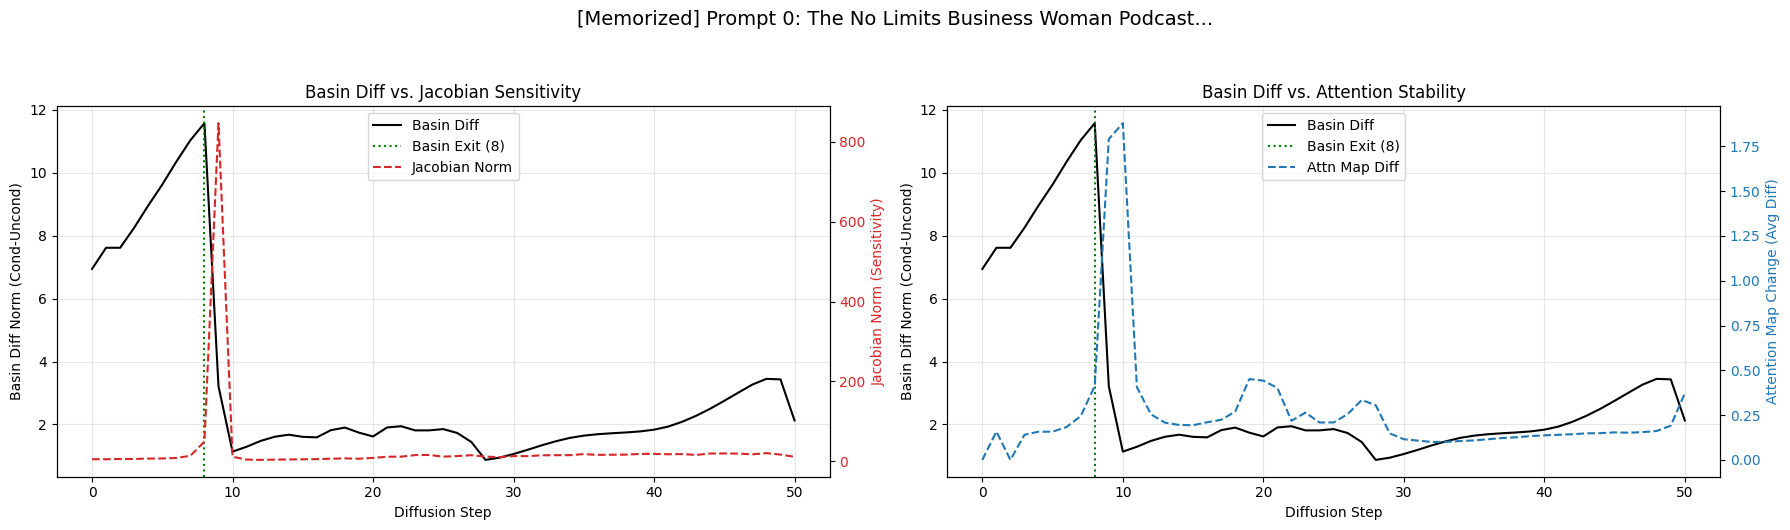

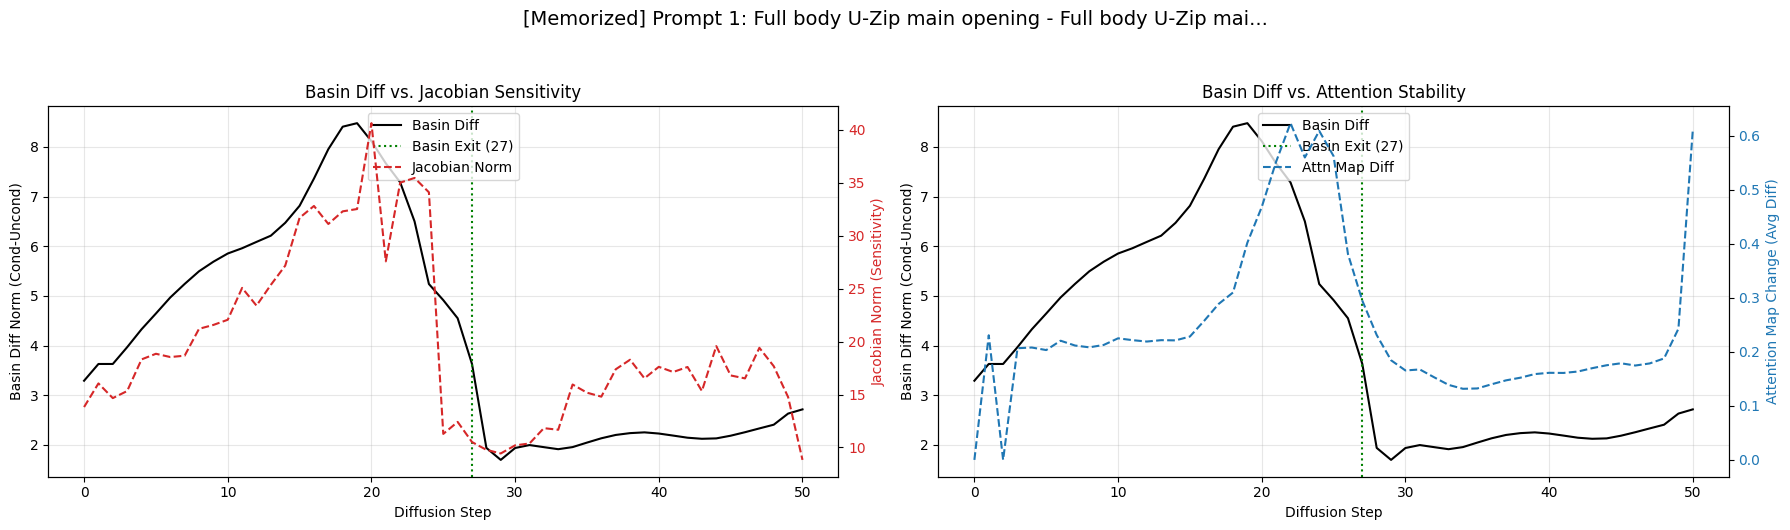

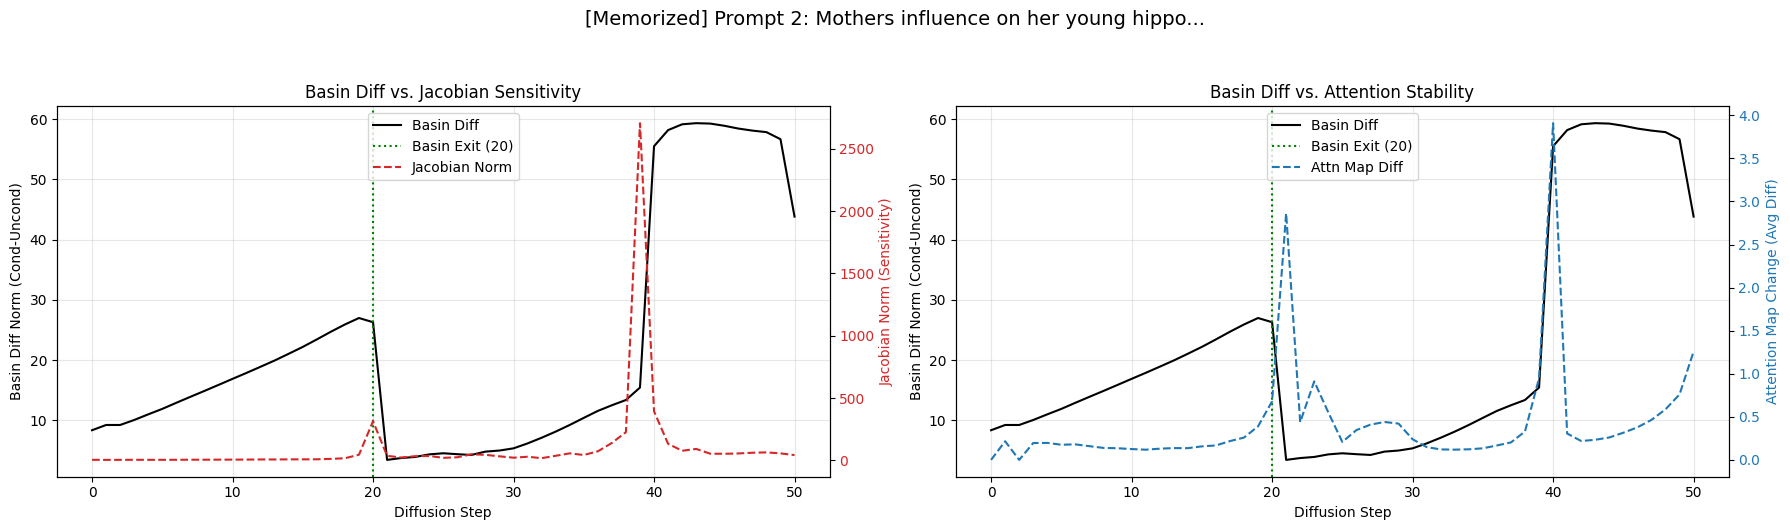

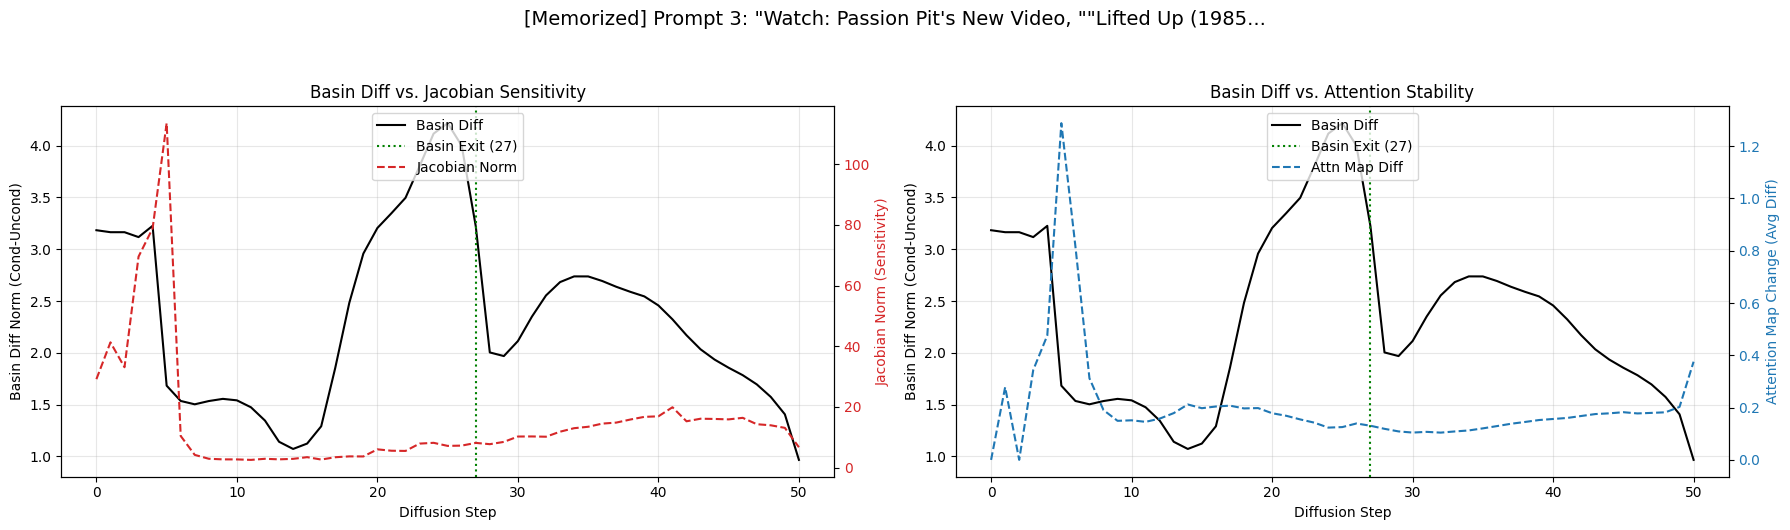

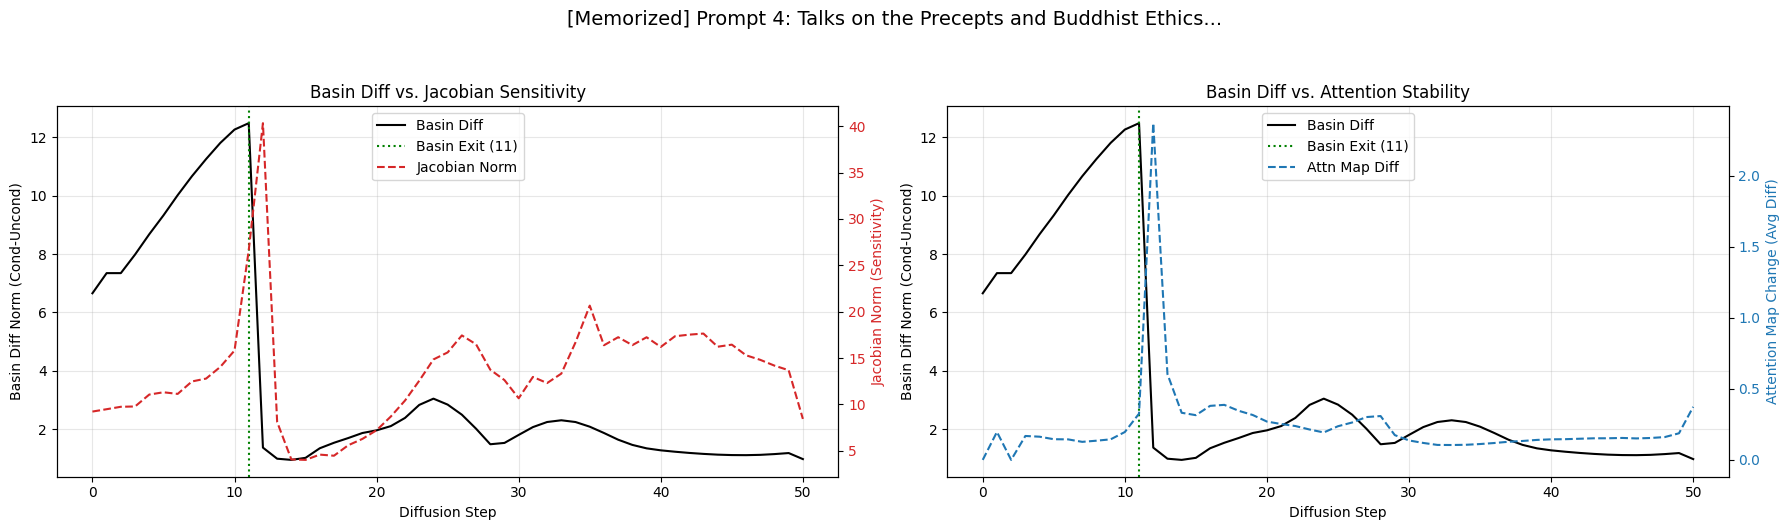

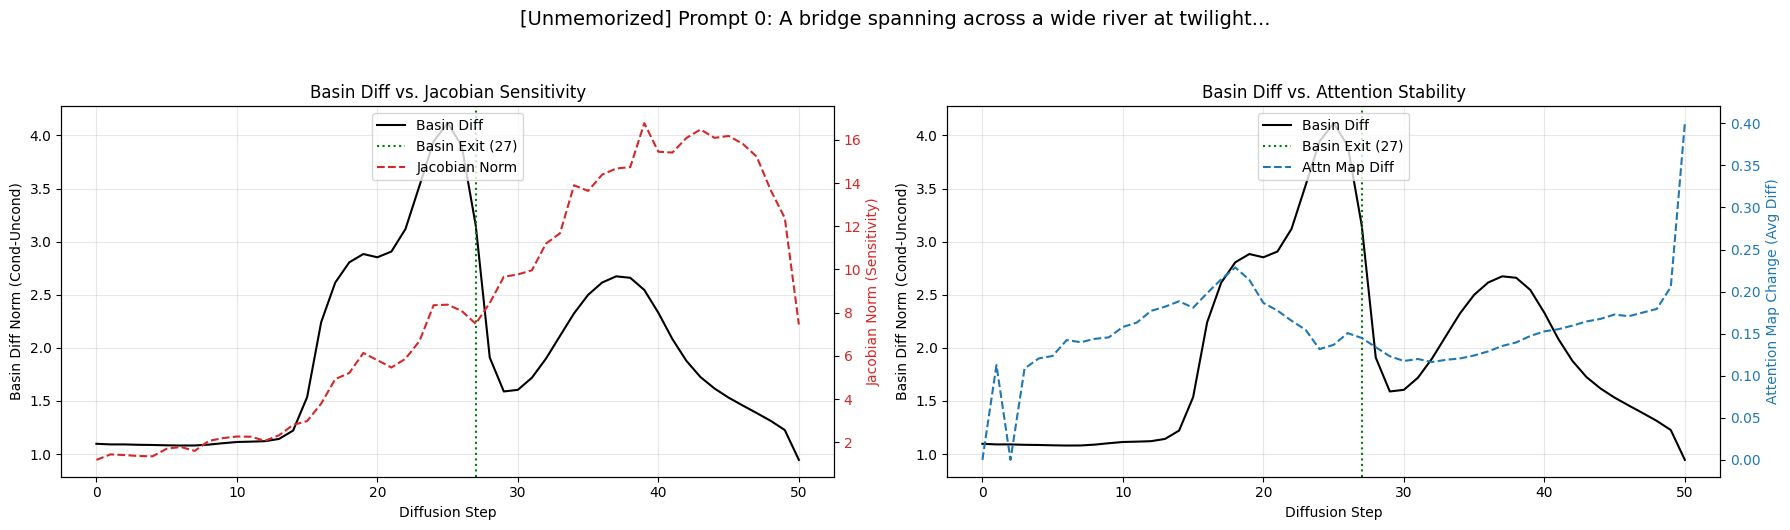

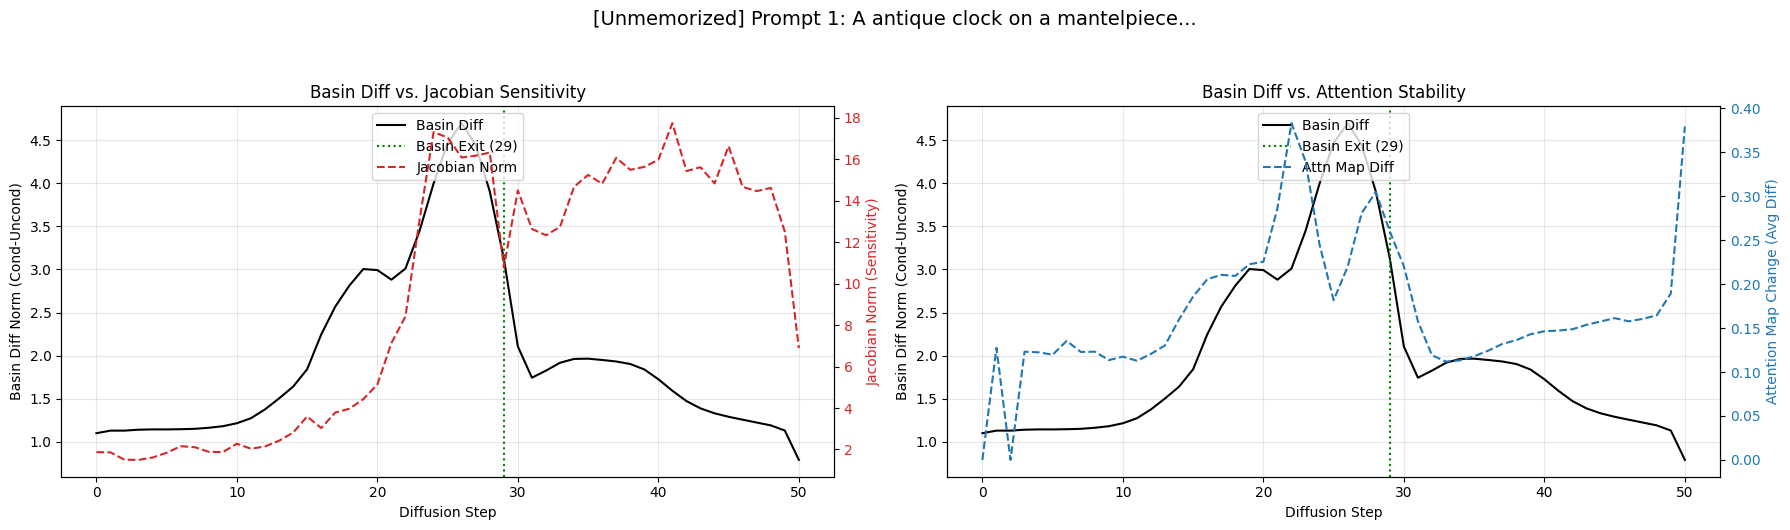

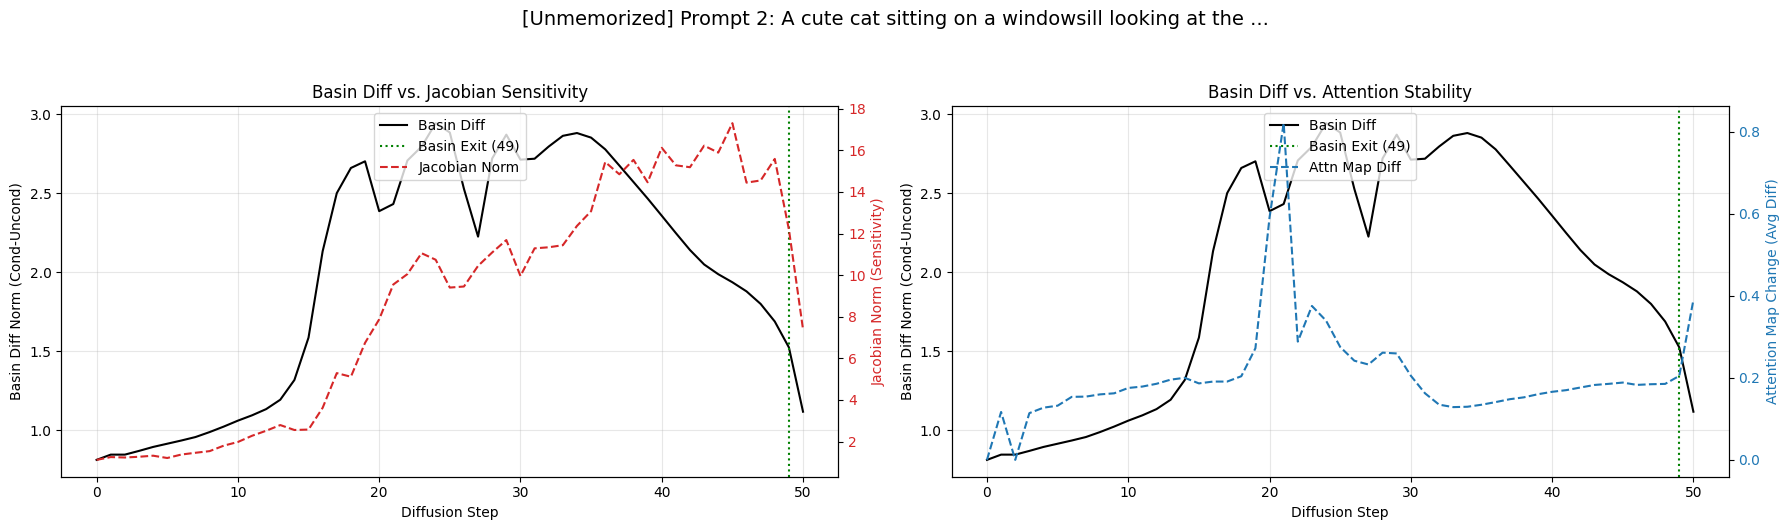

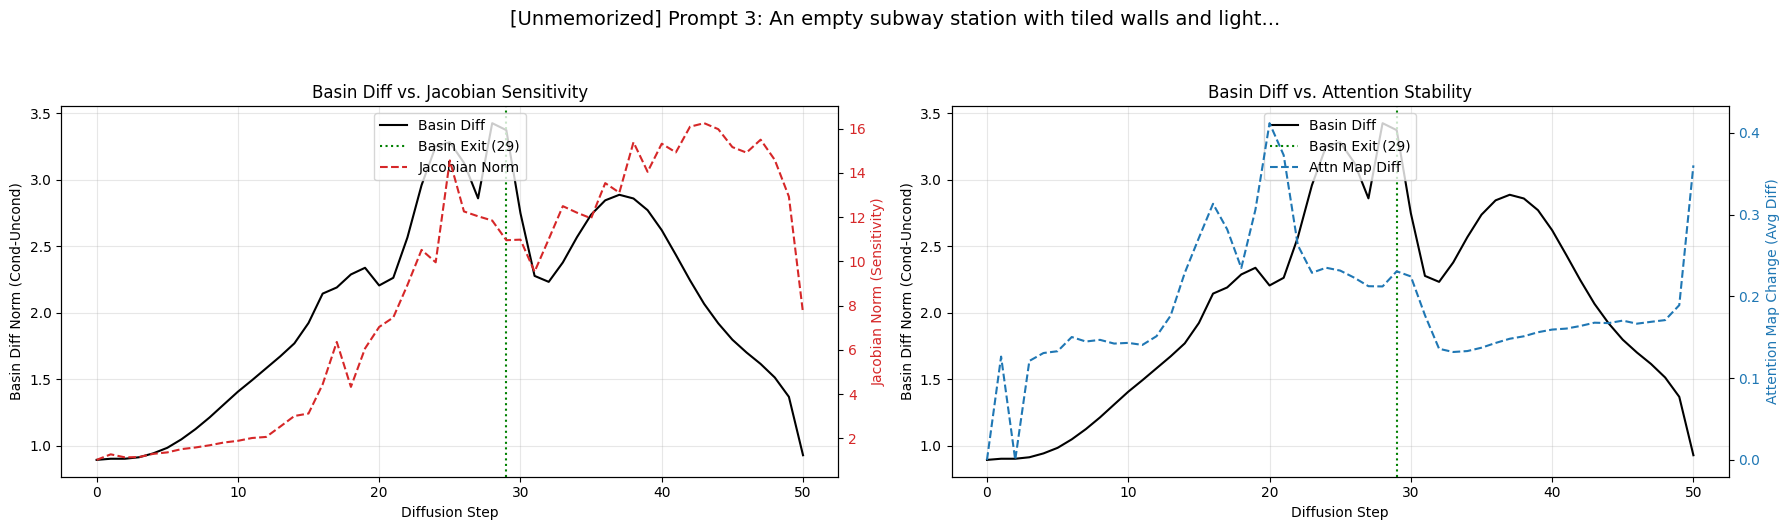

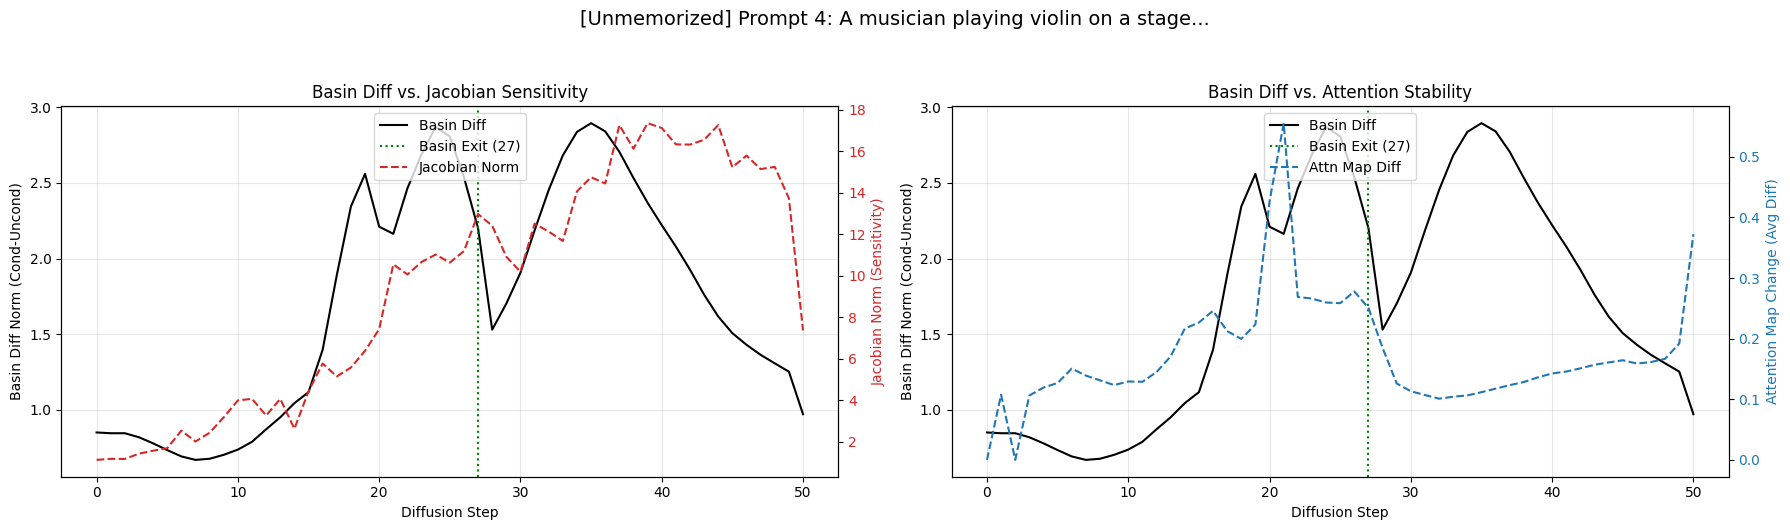

In [15]:
import matplotlib.pyplot as plt

def visualize_combined_dynamics(results, title_prefix=""):
    """
    Visualizes Diff Norm vs Jacobian and Diff Norm vs Attention for each prompt.
    """
    n_samples = len(results)
    
    for i, res in enumerate(results):
        prompt = res['Prompt']
        curve = res['Curve']                # Diff Norm
        j_curve = res['Jacobian_Curve']     # Jacobian Norm
        a_curve = res['Attn_Diff_Curve']    # Attn Map Diff
        drop_idx = res['Drop_Index']
        
        # Create 2 Subplots per prompt
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
        
        # --- Plot 1: Diff Norm vs Jacobian Norm ---
        color = 'black'
        ax1.set_xlabel('Diffusion Step')
        ax1.set_ylabel('Basin Diff Norm (Cond-Uncond)', color=color)
        ax1.plot(curve, color=color, label='Basin Diff')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.grid(True, alpha=0.3)
        
        # Twin Axis for Jacobian
        ax1_twin = ax1.twinx()
        color = 'tab:red'
        ax1_twin.set_ylabel('Jacobian Norm (Sensitivity)', color=color)
        ax1_twin.plot(j_curve, color=color, linestyle='--', label='Jacobian Norm')
        ax1_twin.tick_params(axis='y', labelcolor=color)
        
        # Basin Exit Line
        ax1.axvline(drop_idx, color='green', linestyle=':', label=f'Basin Exit ({drop_idx})')
        
        # Legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax1_twin.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center')
        ax1.set_title("Basin Diff vs. Jacobian Sensitivity")
        
        
        # --- Plot 2: Diff Norm vs Attention Stability ---
        color = 'black'
        ax2.set_xlabel('Diffusion Step')
        ax2.set_ylabel('Basin Diff Norm (Cond-Uncond)', color=color)
        ax2.plot(curve, color=color, label='Basin Diff')
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.grid(True, alpha=0.3)
        
        # Twin Axis for Attention
        ax2_twin = ax2.twinx()
        color = 'tab:blue'
        ax2_twin.set_ylabel('Attention Map Change (Avg Diff)', color=color)
        ax2_twin.plot(a_curve, color=color, linestyle='--', label='Attn Map Diff')
        ax2_twin.tick_params(axis='y', labelcolor=color)
        
        # Basin Exit Line
        ax2.axvline(drop_idx, color='green', linestyle=':', label=f'Basin Exit ({drop_idx})')
        
        # Legend
        lines3, labels3 = ax2.get_legend_handles_labels()
        lines4, labels4 = ax2_twin.get_legend_handles_labels()
        ax2.legend(lines3 + lines4, labels3 + labels4, loc='upper center')
        ax2.set_title("Basin Diff vs. Attention Stability")
        
        plt.suptitle(f"[{title_prefix}] Prompt {i}: {prompt[:50]}...", fontsize=14, y=1.05)
        plt.tight_layout()
        plt.show()

# Run Visualization
if 'mem_results' in locals() and pure_mem_results:
    visualize_combined_dynamics(pure_mem_results, "Memorized")

if 'unmem_results' in locals() and pure_unmem_results:
    visualize_combined_dynamics(pure_unmem_results, "Unmemorized")

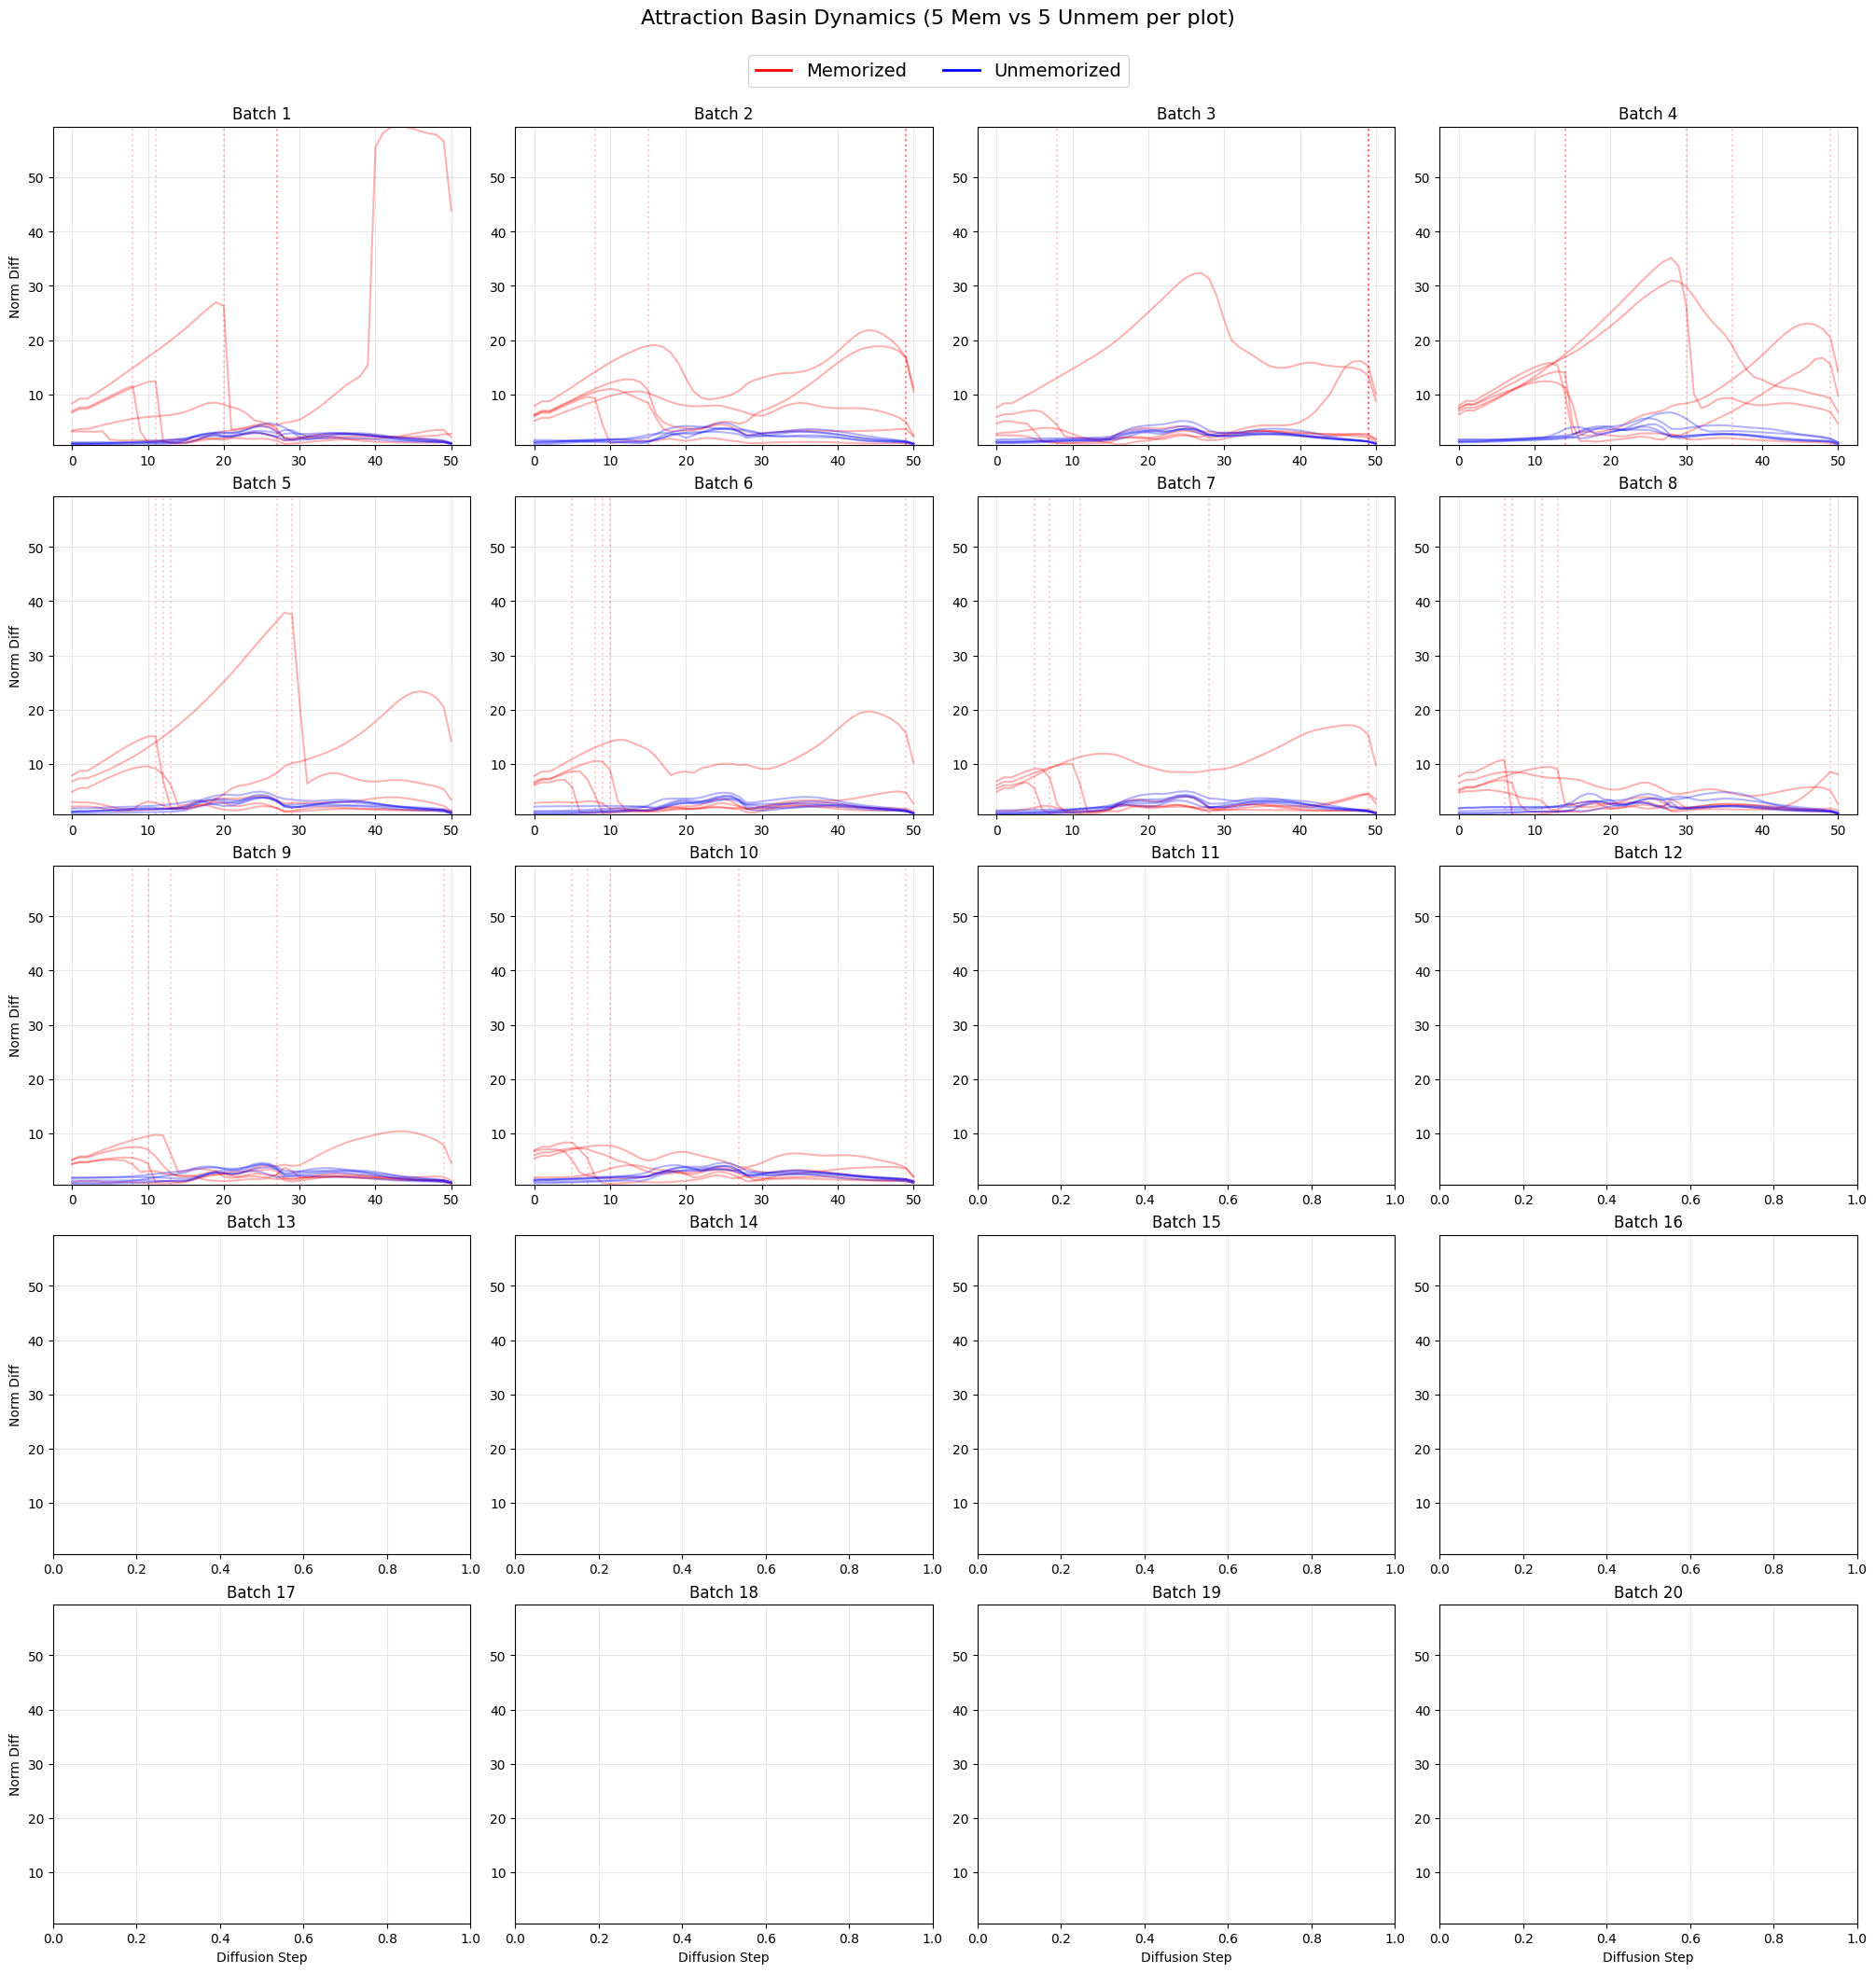

In [ ]:
import math
from matplotlib.lines import Line2D

# Calculate Global Y-Limits for Unified Scale
all_curves = [res['Curve'] for res in pure_mem_results] + [res['Curve'] for res in pure_unmem_results]
if all_curves:
    global_max = max([np.max(c) for c in all_curves])
    global_min = min([np.min(c) for c in all_curves])
else:
    global_max = 1.0
    global_min = 0.0

# Setup Subplots (5x4 grid = 20 plots)
n_subplots = 20
cols = 4
rows = math.ceil(n_subplots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows), constrained_layout=True)
axes = axes.flatten()

samples_per_plot = 5

for i in range(n_subplots):
    if i >= len(axes): break
    ax = axes[i]
    start_idx = i * samples_per_plot
    end_idx = (i + 1) * samples_per_plot
    
    # Memorized Subset
    subset_mem = pure_mem_results[start_idx:end_idx] if start_idx < len(pure_mem_results) else []
    for res in subset_mem:
        ax.plot(res['Curve'], color='red', alpha=0.3)
        ax.axvline(res['Drop_Index'], color='red', linestyle=':', alpha=0.2)
        
    # Unmemorized Subset
    subset_unmem = pure_unmem_results[start_idx:end_idx] if start_idx < len(pure_unmem_results) else []
    for res in subset_unmem:
        ax.plot(res['Curve'], color='blue', alpha=0.3)
        
    # Set Unified Y-Limit
    ax.set_ylim(global_min, global_max)
    ax.set_title(f"Batch {i+1}")
    ax.grid(True, alpha=0.3)
    if i >= (rows-1)*cols: # Last row
        ax.set_xlabel("Diffusion Step")
    if i % cols == 0: # First col
        ax.set_ylabel("Norm Diff")
    
# Legend
custom_lines = [Line2D([0], [0], color='red', lw=2), 
                Line2D([0], [0], color='blue', lw=2)]
fig.legend(custom_lines, ['Memorized', 'Unmemorized'], loc='upper center', ncol=2, fontsize=14, bbox_to_anchor=(0.5, 1.03))

plt.suptitle(f"Attraction Basin Dynamics (5 Mem vs 5 Unmem per plot)", fontsize=16, y=1.05)
plt.show()

### 6. Robustness Analysis across 100 Seeds
특정 Memorized Prompt에 대해 초기 Noise($z_T$)를 100가지 다른 Seed로 생성했을 때, Attraction Basin의 경향성이 유지되는지 확인합니다.

In [9]:
# Target Prompt Selection
target_prompt = memorized_prompts[0]
print(f"Target Prompt: {target_prompt}")

robustness_results = []
seeds = range(100)

# Pre-encode prompts (fixed)
unc_embeds = pipeline._encode_prompt("", DEVICE, 1, False, None)
cond_embeds = pipeline._encode_prompt(target_prompt, DEVICE, 1, False, None)

print("Running 100 Monte Carlo Simulations...")
for s in tqdm(seeds, desc="Seeds"):
    # 1. Initial Latents for this Seed
    gen = torch.Generator(device=DEVICE).manual_seed(int(s))
    latents = pipeline.prepare_latents(
        1, pipeline.unet.config.in_channels, height, width,
        torch.float32, torch.device(DEVICE), gen, None
    )
    
    # 2. Generate Unconditional Trajectory Data
    curr_latents = latents
    traj_latents = []
    traj_uncond_noise = []
    
    with torch.no_grad():
        for t in timesteps:
            traj_latents.append(curr_latents.clone())
            
            # Uncond Predict
            latent_input = pipeline.scheduler.scale_model_input(curr_latents, t)
            noise_merged = pipeline.unet(latent_input, t, encoder_hidden_states=unc_embeds).sample
            traj_uncond_noise.append(noise_merged.clone())
            
            # Update Latents (Unconditional Path)
            curr_latents = pipeline.scheduler.step(noise_merged, t, curr_latents, return_dict=False)[0]
            
    # 3. Calculate Basin Dynamics along this trajectory
    diff_norms = []
    with torch.no_grad():
        for i, t in enumerate(timesteps):
            lat = traj_latents[i]
            latent_input = pipeline.scheduler.scale_model_input(lat, t)
            
            # Cond Predict
            cond_noise = pipeline.unet(latent_input, t, encoder_hidden_states=cond_embeds).sample
            uncond_noise = traj_uncond_noise[i]
            
            diff = torch.norm(cond_noise - uncond_noise).item()
            diff_norms.append(diff)
            
    # Detect Drop
    curve_arr = np.array(diff_norms)
    deriv = np.diff(curve_arr)
    t_drop_idx = np.argmin(deriv[5:]) + 5
    
    robustness_results.append({
        "Seed": s,
        "Curve": curve_arr,
        "Drop_Index": t_drop_idx
    })

# Visualization
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for res in robustness_results:
    plt.plot(res['Curve'], color='black', alpha=0.05) # Very transparent
# Plot Mean
mean_curve = np.mean([r['Curve'] for r in robustness_results], axis=0)
plt.plot(mean_curve, color='red', linewidth=2, label='Mean Curve')
plt.title(f"Robustness Dynamics (100 Seeds)\nPrompt: {target_prompt[:30]}...")
plt.xlabel("Diffusion Step")
plt.ylabel("Norm Diff")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
drop_indices = [r['Drop_Index'] for r in robustness_results]
sns.histplot(drop_indices, bins=range(0, 52), kde=True, color='purple')
plt.axvline(np.mean(drop_indices), color='r', linestyle='--', label=f'Mean Step: {np.mean(drop_indices):.1f}')
plt.title("Distribution of Attraction Basin Exit Step")
plt.xlabel("Step Index")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Target Prompt: The No Limits Business Woman Podcast
Running 100 Monte Carlo Simulations...


Seeds:   1%|          | 1/100 [00:10<16:53, 10.24s/it]


KeyboardInterrupt: 